In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Load the data
df = pd.read_csv('data/aggregated_df.csv')
df.columns

Index(['match_id', 'inning', 'bowling_team', 'batter', 'batter_total_balls',
       'batter_SR', 'batter_score', 'dismissal_kind', 'date', 'match_type',
       'venue', 'no_of_right_arm_pacers_faced', 'no_of_left_arm_pacers_faced',
       'no_of_right_arm_offspinners_faced',
       'no_of_right_arm_legspinners_faced', 'no_of_left_arm_legspinners_faced',
       'no_of_left_arm_offspinners_faced', 'score_last_5', 'balls_last_5',
       'score_last_1', 'balls_last_1', 'score_last_2', 'balls_last_2',
       'score_last_3', 'balls_last_3', 'score_last_4', 'balls_last_4'],
      dtype='object')

## Add number of innings, avg and S/R up until that match, number of 30+ scores, number of 50+ scores, consistency, and form

In [2]:
df.drop(columns = ['date', 'batter_SR', 'no_of_right_arm_pacers_faced', 'no_of_left_arm_pacers_faced', 'no_of_right_arm_offspinners_faced', 
                        'no_of_right_arm_legspinners_faced', 'no_of_left_arm_legspinners_faced', 'no_of_left_arm_offspinners_faced', 
                        'score_last_5', 'balls_last_5', 'score_last_1', 'balls_last_1', 'score_last_2', 'balls_last_2', 'score_last_3', 
                        'balls_last_3', 'score_last_4', 'balls_last_4'], inplace = True)
df.columns

Index(['match_id', 'inning', 'bowling_team', 'batter', 'batter_total_balls',
       'batter_score', 'dismissal_kind', 'match_type', 'venue'],
      dtype='object')

In [3]:
# pd.isna(df['dismissal_kind'][len(df)-1])

In [4]:
df['dismissed'] = df['dismissal_kind'].notna().astype(int)

In [5]:
df['dismissed']

0        0
1        1
2        0
3        1
4        1
        ..
15461    1
15462    1
15463    0
15464    1
15465    0
Name: dismissed, Length: 15466, dtype: int32

In [6]:
df.drop(columns = 'dismissal_kind', inplace = True)

In [7]:
df.columns

Index(['match_id', 'inning', 'bowling_team', 'batter', 'batter_total_balls',
       'batter_score', 'match_type', 'venue', 'dismissed'],
      dtype='object')

In [8]:
df['cumulative_runs'] = df.groupby('batter')['batter_score'].cumsum()
df['cumulative_dismissals'] = df.groupby('batter')['dismissed'].cumsum()
df['cumulative_balls_faced'] = df.groupby('batter')['batter_total_balls'].cumsum()

# Average up until the previous match
shifted_runs = df.groupby('batter')['cumulative_runs'].shift(1)
shifted_dismissals = df.groupby('batter')['cumulative_dismissals'].shift(1)
shifted_balls = df.groupby('batter')['cumulative_balls_faced'].shift(1)

df['average'] = np.where(shifted_dismissals == 0, shifted_runs, shifted_runs / shifted_dismissals)
df.groupby('batter')['cumulative_runs'].shift(1) / df.groupby('batter')['cumulative_dismissals'].shift(1)

# Strike rate up until the previous match
df['strike_rate'] = (df.groupby('batter')['cumulative_runs'].shift(1) / df.groupby('batter')['cumulative_balls_faced'].shift(1)) * 100

# Handling initial matches
# df['average'].fillna(0, inplace = True)
df.fillna({"average": 0, "strike_rate": 0}, inplace = True)
# df['strike_rate'].fillna(0, inplace = True) 

In [9]:
# Cumulative 30+ scores up until the previous match
df['cumulative_30_plus_inclusive'] = df.groupby('batter')['batter_score'].apply(lambda x: (x.apply(lambda score: 1 if 30 <= score < 50 else 0)).cumsum()).reset_index(level=0, drop=True)
df['cumulative_30_plus'] = df.groupby('batter')['cumulative_30_plus_inclusive'].shift(1).fillna(0).astype(int)

# Cumulative 50+ scores up until the previous match
df['cumulative_50_plus_inclusive'] = df.groupby('batter')['batter_score'].apply(lambda x: (x.apply(lambda score: 1 if score >= 50 else 0)).cumsum()).reset_index(level=0, drop=True)
df['cumulative_50_plus'] = df.groupby('batter')['cumulative_50_plus_inclusive'].shift(1).fillna(0).astype(int)

df['innings_played'] = df.groupby('batter')['inning'].cumcount() + 1

In [10]:
df = df.drop(columns = ["cumulative_runs", "cumulative_dismissals", "cumulative_balls_faced", "cumulative_30_plus_inclusive", "cumulative_50_plus_inclusive"])
df.tail()

,match_id,inning,bowling_team,batter,batter_total_balls,batter_score,match_type,venue,dismissed,average,strike_rate,cumulative_30_plus,cumulative_50_plus,innings_played
15461,1370353,2,Gujarat Titans,DP Conway,25.0,47,Final,"Narendra Modi Stadium, Ahmedabad",1,46.157895,139.427663,4,9,22
15462,1370353,2,Gujarat Titans,MS Dhoni,1.0,0,Final,"Narendra Modi Stadium, Ahmedabad",1,37.094891,135.955056,41,24,217
15463,1370353,2,Gujarat Titans,RA Jadeja,6.0,15,Final,"Narendra Modi Stadium, Ahmedabad",0,25.254717,128.270244,19,2,169
15464,1370353,2,Gujarat Titans,RD Gaikwad,16.0,26,Final,"Narendra Modi Stadium, Ahmedabad",1,41.186047,135.190840,13,15,51
15465,1370353,2,Gujarat Titans,S Dube,21.0,32,Final,"Narendra Modi Stadium, Ahmedabad",0,28.263158,141.501976,5,6,47


In [11]:
df.columns

Index(['match_id', 'inning', 'bowling_team', 'batter', 'batter_total_balls',
       'batter_score', 'match_type', 'venue', 'dismissed', 'average',
       'strike_rate', 'cumulative_30_plus', 'cumulative_50_plus',
       'innings_played'],
      dtype='object')

- No. of matches
- Avg
- S/R
- no of 30
- no of 50
######
- 1 is equal importance
- 3 is moderate of one over another
- 5 is essential
- 7 is very strong
- 9 is extreme importance
######
0    1    2     3     4     5

1    1    1/4   1/6   1/3   1/4

2    4    1     1/3   3     2

3    6    3     1     6     5

4    3    1/3   1/6   1     1/2

5    4    1/2   1/5   2     1



In [12]:
# Main comparison matrix (transposed)
matrix = np.array([
    [1,    1/4,  1/6,  1/3,  1/4],
    [4,    1,    1/3,  3,    2  ],
    [6,    3,    1,    6,    5  ],
    [3,    1/3,  1/6,  1,    1/2],
    [4,    1/2,  1/5,  2,    1  ]
])

In [13]:
A1 = np.ones((5,1))

for i in range(5):
    for j in range(5):
        A1[i][0] *= matrix[i][j]
    A1[i][0] = A1[i][0]**(1/5)

# A1 = np.prod(matrix, axis=1) ** (1/5)
# A1 = A1.reshape(-1, 1)

np.set_printoptions(suppress=True)
A1

array([[0.32219701],
       [1.51571657],
       [3.51948203],
       [0.60836434],
       [0.9563525 ]])

In [14]:
summation = A1.sum()
summation

6.922112444617791

In [15]:
A2 = A1/summation
A2

array([[0.04654605],
       [0.21896734],
       [0.50844046],
       [0.08788709],
       [0.13815905]])

In [16]:
#ahp = np.ones((5,1))
AHP = np.dot(matrix,A2)
AHP

array([[0.24986343],
       [1.11461109],
       [2.66273662],
       [0.45433397],
       [0.71128921]])

In [17]:
A4 = AHP/A2
A4

array([[5.3680906 ],
       [5.09030743],
       [5.23706675],
       [5.16951864],
       [5.14833589]])

In [18]:
mean = A4.mean()
mean
CI = (mean - 5) / 4
CI
CR = CI/1.11
CR
# CR SHOULD BE LESS THAN 0.1 

0.045645014310930376

In [19]:
df['avg_ahp'] = df['average'].apply(lambda x: 1 if x < 20 else (2 if 20 <= x < 25 else (3 if 25 <= x < 30 else (4 if 30 <= x < 40 else (5 if x >= 40 else None)))))

# bins = [-float('inf'), 10, 20, 30, 40, float('inf')]
# labels = [1, 2, 3, 4, 5]

# df['avg_ahp'] = pd.cut(df['average'], bins=bins, labels=labels, right=False)

df['sr_ahp'] = df['strike_rate'].apply(lambda x: 1 if x < 100 else (2 if 100 <= x < 120 else (3 if 120 <= x < 140 else (4 if 140 <= x < 160 else (5 if x >= 160 else None)))))

df['innings_ahp'] = df['innings_played'].apply(lambda x: 1 if x < 20 else (2 if 20 <= x < 40 else (3 if 40 <= x < 60 else (4 if 60 <= x < 80 else (5 if x >= 80 else None)))))

df['30_ahp'] = df['cumulative_30_plus'].apply(lambda x: 1 if x < 5 else (2 if 5 <= x < 15 else (3 if 15 <= x < 25 else (4 if 25 <= x < 35 else (5 if x >= 35 else None)))))

df['50_ahp'] = df['cumulative_50_plus'].apply(lambda x: 1 if x < 5 else (2 if 5 <= x < 10 else (3 if 10 <= x < 20 else (4 if 20 <= x < 25 else (5 if x >= 25 else None)))))

df['consistency'] = df['innings_ahp']*AHP[0][0] + df['avg_ahp']*AHP[1][0] + df['sr_ahp']*AHP[2][0] + df['30_ahp']*AHP[3][0] + df['50_ahp']*AHP[4][0]

df.tail()

,match_id,inning,bowling_team,batter,batter_total_balls,batter_score,match_type,venue,dismissed,average,strike_rate,cumulative_30_plus,cumulative_50_plus,innings_played,avg_ahp,sr_ahp,innings_ahp,30_ahp,50_ahp,consistency
15461,1370353,2,Gujarat Titans,DP Conway,25.0,47,Final,"Narendra Modi Stadium, Ahmedabad",1,46.157895,139.427663,4,9,22,5,3,2,1,2,15.937905
15462,1370353,2,Gujarat Titans,MS Dhoni,1.0,0,Final,"Narendra Modi Stadium, Ahmedabad",1,37.094891,135.955056,41,24,217,4,3,5,5,4,18.812798
15463,1370353,2,Gujarat Titans,RA Jadeja,6.0,15,Final,"Narendra Modi Stadium, Ahmedabad",0,25.254717,128.270244,19,2,169,3,3,5,3,1,14.655651
15464,1370353,2,Gujarat Titans,RD Gaikwad,16.0,26,Final,"Narendra Modi Stadium, Ahmedabad",1,41.186047,135.190840,13,15,51,5,3,3,2,3,17.353391
15465,1370353,2,Gujarat Titans,S Dube,21.0,32,Final,"Narendra Modi Stadium, Ahmedabad",0,28.263158,141.501976,5,6,47,3,4,3,2,2,17.075616


In [20]:
last_5_dismissed = []

In [21]:
# Step 1: Sort the DataFrame by batter and match_id
df_sorted = df.sort_values(by=['batter', 'match_id'])

# Step 2: Group by batter
grouped = df_sorted.groupby('batter', group_keys=False)

# Step 3: Calculate rolling statistics
rolling_stats = grouped.apply(
    lambda x: x.assign(
        total_runs_5_inc=x['batter_score'].rolling(5, min_periods=1).sum(),
        balls_faced_5_inc=x['batter_total_balls'].rolling(5, min_periods=1).sum(),
        dismissals_5_inc=x['dismissed'].rolling(5, min_periods=1).sum(),
        no_of_30_plus_5_inc=x['batter_score'].rolling(5, min_periods=1).apply(lambda y: ((y >= 30) & (y < 50)).sum()),
        no_of_50_plus_5_inc=x['batter_score'].rolling(5, min_periods=1).apply(lambda y: (y >= 50).sum())
    )
)

rolling_stats = rolling_stats.reset_index(drop=True)

rolling_stats['total_runs_5'] = rolling_stats.groupby('batter')['total_runs_5_inc'].shift(1).fillna(0).astype(int)
rolling_stats['balls_faced_5'] = rolling_stats.groupby('batter')['balls_faced_5_inc'].shift(1).fillna(0).astype(int)
rolling_stats['dismissals_5'] = rolling_stats.groupby('batter')['dismissals_5_inc'].shift(1).fillna(0).astype(int)
rolling_stats['no_of_30_plus_5'] = rolling_stats.groupby('batter')['no_of_30_plus_5_inc'].shift(1).fillna(0).astype(int)
rolling_stats['no_of_50_plus_5'] = rolling_stats.groupby('batter')['no_of_50_plus_5_inc'].shift(1).fillna(0).astype(int)

# # Calculate mean for the first 4 matches
# means = rolling_stats.groupby('batter')[['total_runs_5', 'balls_faced_5', 'dismissals_5', 'no_of_30_plus_5', 'no_of_50_plus_5']].transform('mean')
# means = means.astype(float)

# # Replace the first 4 matches with the mean
# for col in ['total_runs_5', 'balls_faced_5', 'dismissals_5', 'no_of_30_plus_5', 'no_of_50_plus_5']:
#     rolling_stats.loc[rolling_stats.groupby('batter').cumcount() < 4, col] = means[col].astype(rolling_stats[col].dtype)

# Reset index to match the original DataFrame
rolling_stats = rolling_stats.reset_index(drop=True)

# Step 4: Compute required metrics
rolling_stats['average_5'] = np.where(
    rolling_stats['dismissals_5'] == 0,
    rolling_stats['total_runs_5'],
    rolling_stats['total_runs_5'] / rolling_stats['dismissals_5']
)
rolling_stats['strike_rate_5'] = rolling_stats['total_runs_5'] / rolling_stats['balls_faced_5'] * 100

rolling_stats.loc[rolling_stats.groupby('batter').cumcount() < 5, ['no_of_30_plus_5', 'no_of_50_plus_5', 'average_5', 'strike_rate_5']] = 0

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_30864\3110349524.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rolling_stats = grouped.apply(


In [22]:
df = pd.merge(df, rolling_stats[['total_runs_5', 'balls_faced_5', 'dismissals_5', 'no_of_30_plus_5', 'no_of_50_plus_5', 'average_5', 'strike_rate_5', 'batter', 'match_id']], on = ['batter', 'match_id'], how = 'left')

df.describe()

,match_id,inning,batter_total_balls,batter_score,dismissed,average,strike_rate,cumulative_30_plus,cumulative_50_plus,innings_played,...,30_ahp,50_ahp,consistency,total_runs_5,balls_faced_5,dismissals_5,no_of_30_plus_5,no_of_50_plus_5,average_5,strike_rate_5
count,1.559800e+04,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,...,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000,15598.000000
mean,8.714303e+05,1.508847,15.384536,19.961469,0.761316,24.977316,121.627021,7.234133,6.140403,43.598731,...,1.719515,1.741954,13.217555,93.813694,71.704257,3.439415,0.638223,0.507629,24.860312,106.640348
std,3.541843e+05,0.537512,13.559695,21.285340,0.426293,12.975611,37.635442,8.942576,9.452094,45.443286,...,0.960323,1.153766,4.654858,65.289572,44.937954,1.477020,0.829873,0.794956,22.480243,54.726463
min,3.359820e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,5.192834,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.483140e+05,1.000000,5.000000,4.000000,1.000000,17.090909,115.850004,0.000000,0.000000,9.000000,...,1.000000,1.000000,10.084793,43.000000,37.000000,3.000000,0.000000,0.000000,10.000000,93.158468
50%,8.298190e+05,1.000000,11.000000,13.000000,1.000000,26.234152,128.178211,4.000000,2.000000,27.000000,...,1.000000,1.000000,13.825907,87.000000,69.000000,4.000000,0.000000,0.000000,21.800000,120.833333
75%,1.216509e+06,2.000000,22.000000,29.000000,1.000000,32.318907,139.223111,11.000000,9.000000,64.000000,...,2.000000,2.000000,16.774741,135.000000,102.000000,5.000000,1.000000,1.000000,34.333333,140.659341
max,1.370353e+06,6.000000,73.000000,175.000000,1.000000,176.000000,600.000000,47.000000,64.000000,238.000000,...,5.000000,5.000000,23.640017,389.000000,255.000000,5.000000,5.000000,5.000000,306.000000,282.352941


- No. of matches
- Avg
- S/R
- no of 30
- no of 50
######
- 1 is equal importance
- 3 is moderate of one over another
- 5 is essential
- 7 is very strong
- 9 is extreme importance
######
0    1    2     3     4     5

1    1    1/4   1/6   1/4   1/7

2    4    1     1/3   2     1/3

3    6    3     1     4     1/2

4    4    1/2   1/4   1     1/3

5    7    3     2     3     1 




In [23]:
matrix = np.array([
    [1,    1/3,  2,    1/3],
    [3,    1,    4,    1/2],
    [1/2,  1/4,  1,    1/3],
    [3,    2,    3,    1]
])



In [24]:
A1 = np.ones((4,1))

for i in range(4):
    for j in range(4):
        A1[i][0] *= matrix[i][j]
    A1[i][0] = A1[i][0]**(1/4)
# A1 = np.prod(matrix, axis=1) ** (1/5)
# A1 = A1.reshape(-1, 1)
np.set_printoptions(suppress=True)
A1

array([[0.68658905],
       [1.56508458],
       [0.451801  ],
       [2.05976714]])

In [25]:
summation = A1.sum()
summation
A2 = A1/summation
A2

array([[0.14414323],
       [0.32857551],
       [0.09485158],
       [0.43242969]])

In [26]:
#AHP = np.ones((5,1))
AHP = np.dot(matrix,A2)
AHP

array([[0.58751478],
       [1.35662635],
       [0.3932103 ],
       [1.80656512]])

In [27]:
A4 = AHP/A2
A4

array([[4.0759097 ],
       [4.12881156],
       [4.14553246],
       [4.17770838]])

In [28]:
mean = A4.mean()
mean
CI = (mean - 4) / 3
CI

0.04399684124422679

In [29]:
CR = CI/0.89
CR
# CR SHOULD BE LESS THAN 0.1 

0.04943465308340089

In [30]:
df['avg_fahp'] = df['average_5'].apply(lambda x: 1 if x < 20 else (2 if 20 <= x < 30 else (3 if 30 <= x < 40 else (4 if 40 <= x < 60 else (5 if x >= 60 else None)))))

# bins = [-float('inf'), 10, 20, 30, 40, float('inf')]
# labels = [1, 2, 3, 4, 5]

# df['avg_fahp'] = pd.cut(df['average'], bins=bins, labels=labels, right=False)

df['sr_fahp'] = df['strike_rate_5'].apply(lambda x: 1 if x < 110 else (2 if 110 <= x < 130 else (3 if 130 <= x < 160 else (4 if 160 <= x < 200 else (5 if x >= 200 else None)))))

# df['innings_fahp'] = df['innings_played'].apply(lambda x: 1 if x < 20 else (2 if 20 <= x < 40 else (3 if 40 <= x < 60 else (4 if 60 <= x < 80 else (5 if x >= 80 else None)))))

df['30_fahp'] = df['no_of_30_plus_5'].apply(lambda x: 1 if x < 2 else (2 if 2 <= x < 3 else (3 if 3 <= x < 4 else (4 if 4 <= x < 5 else (5 if x >= 5 else None)))))

df['50_fahp'] = df['no_of_50_plus_5'].apply(lambda x: 1 if x < 2 else (2 if 2 <= x < 3 else (3 if 3 <= x < 4 else (4 if 4 <= x < 5 else (5 if x >= 5 else None)))))

df['form'] = df['avg_fahp']*AHP[0][0] + df['sr_fahp']*AHP[1][0] + df['30_fahp']*AHP[2][0] + df['50_fahp']*AHP[3][0]

df.tail()

,match_id,inning,bowling_team,batter,batter_total_balls,batter_score,match_type,venue,dismissed,average,...,dismissals_5,no_of_30_plus_5,no_of_50_plus_5,average_5,strike_rate_5,avg_fahp,sr_fahp,30_fahp,50_fahp,form
15593,1370353,2,Gujarat Titans,DP Conway,25.0,47,Final,"Narendra Modi Stadium, Ahmedabad",1,46.157895,...,5,3,1,42.200000,124.852071,4,2,3,1,8.049508
15594,1370353,2,Gujarat Titans,MS Dhoni,1.0,0,Final,"Narendra Modi Stadium, Ahmedabad",1,37.094891,...,2,0,0,15.000000,142.857143,1,3,1,1,6.857169
15595,1370353,2,Gujarat Titans,RA Jadeja,6.0,15,Final,"Narendra Modi Stadium, Ahmedabad",0,25.254717,...,4,0,0,23.750000,130.136986,2,3,1,1,7.444684
15596,1370353,2,Gujarat Titans,RD Gaikwad,16.0,26,Final,"Narendra Modi Stadium, Ahmedabad",1,41.186047,...,5,1,2,42.000000,148.936170,4,3,1,2,10.426279
15597,1370353,2,Gujarat Titans,S Dube,21.0,32,Final,"Narendra Modi Stadium, Ahmedabad",0,28.263158,...,3,1,0,40.666667,160.526316,4,4,1,1,9.976340


In [31]:
df.columns

Index(['match_id', 'inning', 'bowling_team', 'batter', 'batter_total_balls',
       'batter_score', 'match_type', 'venue', 'dismissed', 'average',
       'strike_rate', 'cumulative_30_plus', 'cumulative_50_plus',
       'innings_played', 'avg_ahp', 'sr_ahp', 'innings_ahp', '30_ahp',
       '50_ahp', 'consistency', 'total_runs_5', 'balls_faced_5',
       'dismissals_5', 'no_of_30_plus_5', 'no_of_50_plus_5', 'average_5',
       'strike_rate_5', 'avg_fahp', 'sr_fahp', '30_fahp', '50_fahp', 'form'],
      dtype='object')

In [32]:
model_df = pd.DataFrame()
#model_df[['batter', 'inning', 'bowling_team', 'consistency', 'form', 'batter_score']] = df[['batter','inning', 'bowling_team', 'consistency', 'form', 'batter_score']]
model_df[['batter', 'inning', 'bowling_team', 'average', 'strike_rate', 'cumulative_30_plus', 'cumulative_50_plus', 'innings_played', 'no_of_30_plus_5', 'no_of_50_plus_5', 'average_5', 
          'strike_rate_5', 'batter_score']] = df[['batter', 'inning', 'bowling_team', 'average',
       'strike_rate', 'cumulative_30_plus', 'cumulative_50_plus',
       'innings_played', 'no_of_30_plus_5', 'no_of_50_plus_5', 'average_5',
       'strike_rate_5', 'batter_score']]
model_df.head()

,batter,inning,bowling_team,average,strike_rate,cumulative_30_plus,cumulative_50_plus,innings_played,no_of_30_plus_5,no_of_50_plus_5,average_5,strike_rate_5,batter_score
0,BB McCullum,1,Royal Challengers Bangalore,0.0,0.0,0,0,1,0,0,0.0,0.0,158
1,DJ Hussey,1,Royal Challengers Bangalore,0.0,0.0,0,0,1,0,0,0.0,0.0,12
2,Mohammad Hafeez,1,Royal Challengers Bangalore,0.0,0.0,0,0,1,0,0,0.0,0.0,5
3,RT Ponting,1,Royal Challengers Bangalore,0.0,0.0,0,0,1,0,0,0.0,0.0,20
4,SC Ganguly,1,Royal Challengers Bangalore,0.0,0.0,0,0,1,0,0,0.0,0.0,10


In [33]:
player = 'V Kohli'
gdf = model_df[model_df['batter'] == player]
gdf.drop(columns=['batter'], inplace=True)

C:\Users\Pranav Koka\AppData\Local\Temp\ipykernel_30864\3227728890.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdf.drop(columns=['batter'], inplace=True)


In [34]:
gdf.columns

Index(['inning', 'bowling_team', 'average', 'strike_rate',
       'cumulative_30_plus', 'cumulative_50_plus', 'innings_played',
       'no_of_30_plus_5', 'no_of_50_plus_5', 'average_5', 'strike_rate_5',
       'batter_score'],
      dtype='object')

In [35]:
X = gdf.iloc[:, :-1].values
y = gdf.iloc[:, -1].values
X

array([[2, 'Kolkata Knight Riders', 0.0, ..., 0, 0.0, 0.0],
       [2, 'Mumbai Indians', 1.0, ..., 0, 0.0, 0.0],
       [1, 'Rajasthan Royals', 12.0, ..., 0, 0.0, 0.0],
       ...,
       [1, 'Rajasthan Royals', 36.854922279792746, ..., 2, 28.2,
        119.4915254237288],
       [2, 'Sunrisers Hyderabad', 36.75773195876289, ..., 2, 31.8,
        116.91176470588236],
       [1, 'Gujarat Titans', 37.08205128205128, ..., 2, 41.0,
        126.54320987654322]], dtype=object)

In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers = [('encoder', OneHotEncoder(), [1])], remainder = 'passthrough')
X = np.array(ct.fit_transform(X))


In [37]:
X[0]

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 2, 0.0, 0.0, 0, 0, 1, 0, 0, 0.0, 0.0],
      dtype=object)

In [38]:
y = y.reshape(len(y), 1)

In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 5)

In [40]:
X_train.shape[1]

27

In [41]:
# Check for very large values
print("Maximum value in X_train:", np.nanmax(X_train))
print("Maximum value in X_test:", np.nanmax(X_test))

Maximum value in X_train: 230
Maximum value in X_test: 231


In [42]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train[:, X_train.shape[1] - 10:] = sc_X.fit_transform(X_train[:, X_train.shape[1] - 10:])
X_test[:, X_train.shape[1] - 10:] = sc_X.transform(X_test[:, X_train.shape[1] - 10:])
y_train = sc_y.fit_transform(y_train)

In [43]:
y_train = y_train.ravel()
y_test = y_test.ravel()

In [44]:
def MLR(X_train, y_train, X_test, y_test):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    y_pred = sc_y.inverse_transform(regressor.predict(X_test).reshape(-1,1))
    np.set_printoptions(precision=2)
    print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))
    print("r2_score is "+ str(r2_score(y_test, y_pred)))

    # Reshape y_pred and y_test to 1D arrays
    y_pred_1d = y_pred.ravel()
    y_test_1d = y_test.ravel()

    # Create a scatter plot of predicted values vs. actual values
    X = np.linspace(1,len(y_pred_1d) + 1, len(y_pred_1d))
    Y = y_test_1d - y_pred_1d
    plt.bar(X, Y, color = 'red', label = 'Predicted Values')
    plt.xlabel('Test set number')
    plt.ylabel('Actual - Prediction')
    plt.title('Performance')
    plt.show()

In [45]:
def DT(X_train, y_train, X_test, y_test):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn.metrics import r2_score
    regressor = DecisionTreeRegressor(random_state = 0)
    regressor.fit(X_train,y_train)
    y_pred = sc_y.inverse_transform(regressor.predict(X_test).reshape(-1,1))
    np.set_printoptions(precision=2)
    print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))
    print("r2_score is "+ str(r2_score(y_test, y_pred)))

    # Reshape y_pred and y_test to 1D arrays
    y_pred_1d = y_pred.ravel()
    y_test_1d = y_test.ravel()

    # Create a scatter plot of predicted values vs. actual values
    X = np.linspace(1,len(y_pred_1d) + 1, len(y_pred_1d))
    Y = y_test_1d - y_pred_1d
    plt.bar(X, Y, color = 'red', label = 'Predicted Values')
    plt.xlabel('Test set number')
    plt.ylabel('Actual - Prediction')
    plt.title('Performance')
    plt.show()

In [46]:
def RF(X_train, y_train, X_test, y_test):    
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score
    regressor = RandomForestRegressor(n_estimators = 10, random_state = 0)
    regressor.fit(X_train, y_train)
    y_pred = sc_y.inverse_transform(regressor.predict(X_test).reshape(-1,1))
    np.set_printoptions(precision=2)
    print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))
    print("r2_score is "+ str(r2_score(y_test, y_pred)))
    
    # Reshape y_pred and y_test to 1D arrays
    y_pred_1d = y_pred.ravel()
    y_test_1d = y_test.ravel()

    # Create a scatter plot of predicted values vs. actual values
    X = np.linspace(1,len(y_pred_1d) + 1, len(y_pred_1d))
    Y = y_test_1d - y_pred_1d
    plt.bar(X, Y, color = 'red', label = 'Predicted Values')
    plt.xlabel('Test set number')
    plt.ylabel('Actual - Prediction')
    plt.title('Performance')
    plt.show()

In [47]:
def SVR(X_train, y_train, X_test, y_test):    
    from sklearn.svm import SVR
    from sklearn.metrics import r2_score
    import matplotlib.pyplot as plt
    regressor = SVR(kernel = 'rbf')
    regressor.fit(X_train, y_train)
    y_pred = sc_y.inverse_transform(regressor.predict(X_test).reshape(-1,1))
    np.set_printoptions(precision=2)
    print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test), 1)), 1))
    print("r2_score is "+ str(r2_score(y_test, y_pred)))

    # Reshape y_pred and y_test to 1D arrays
    y_pred_1d = y_pred.ravel()
    y_test_1d = y_test.ravel()

    # Create a scatter plot of predicted values vs. actual values
    X = np.linspace(1,len(y_pred_1d) + 1, len(y_pred_1d))
    Y = y_test_1d - y_pred_1d
    plt.bar(X, Y, color = 'red', label = 'Predicted Values')
    plt.xlabel('Test set number')
    plt.ylabel('Actual - Prediction')
    plt.title('Performance')
    plt.show()

[[ 40.21  20.  ]
 [ 30.16  25.  ]
 [ 32.45  43.  ]
 [ 33.55  12.  ]
 [ 38.65  58.  ]
 [  2.61  34.  ]
 [ 27.24  30.  ]
 [ 31.41  82.  ]
 [ 33.7    1.  ]
 [ 28.03   6.  ]
 [ 31.41   0.  ]
 [ 25.89  12.  ]
 [  6.    12.  ]
 [ 31.25   4.  ]
 [ 23.29   9.  ]
 [ 31.46  70.  ]
 [ 35.26  54.  ]
 [ 21.15  25.  ]
 [ 32.97  24.  ]
 [ 24.8   13.  ]
 [ 20.27  46.  ]
 [ 37.3    7.  ]
 [ 35.89  57.  ]
 [ 28.86  20.  ]
 [ 35.58  13.  ]
 [ 32.19  18.  ]
 [ 24.75   2.  ]
 [ 24.48  16.  ]
 [ 36.1   50.  ]
 [ 47.14  79.  ]
 [ 32.56  16.  ]
 [ 23.96  38.  ]
 [ 17.61  72.  ]
 [ 33.08  35.  ]
 [ 25.68  50.  ]
 [ 24.17  27.  ]
 [ 52.66  10.  ]
 [ 43.02  56.  ]
 [ 64.43 101.  ]
 [ 52.19  49.  ]
 [ 29.17  15.  ]
 [ 23.7  100.  ]
 [ 29.64  62.  ]
 [ 39.07   0.  ]
 [ 28.34   7.  ]
 [ 21.05   5.  ]
 [ 23.55   1.  ]]
r2_score is 0.05498651183613179


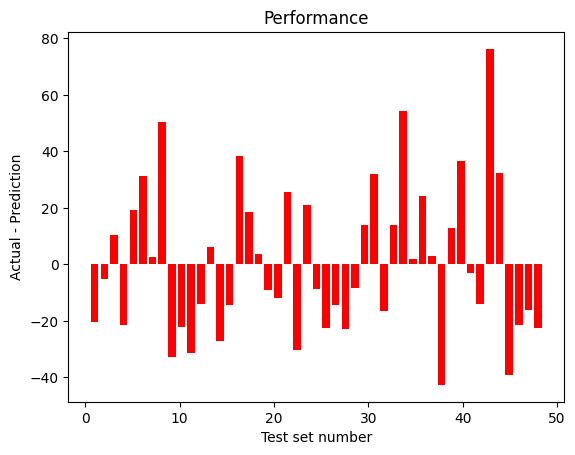

In [48]:
MLR(X_train, y_train, X_test, y_test)

[[ 73.  20.]
 [ 61.  25.]
 [ 93.  43.]
 [ 75.  12.]
 [  8.  58.]
 [ 21.  34.]
 [ 38.  30.]
 [ 61.  82.]
 [ 92.   1.]
 [ 56.   6.]
 [ 17.   0.]
 [  4.  12.]
 [  9.  12.]
 [ 25.   4.]
 [ 23.   9.]
 [ 36.  70.]
 [ 61.  54.]
 [ 12.  25.]
 [ 16.  24.]
 [ 48.  13.]
 [ 33.  46.]
 [  9.   7.]
 [ 93.  57.]
 [ 92.  20.]
 [ 38.  13.]
 [ 51.  18.]
 [ 16.   2.]
 [ 24.  16.]
 [ 31.  50.]
 [ 75.  79.]
 [  4.  16.]
 [ 19.  38.]
 [  5.  72.]
 [ 35.  35.]
 [ 14.  50.]
 [ 56.  27.]
 [ 72.  10.]
 [ 99.  56.]
 [100. 101.]
 [ 14.  49.]
 [ 35.  15.]
 [ 31. 100.]
 [  7.  62.]
 [ 53.   0.]
 [ 32.   7.]
 [  0.   5.]
 [ 48.   1.]]
r2_score is -0.8915821231398882


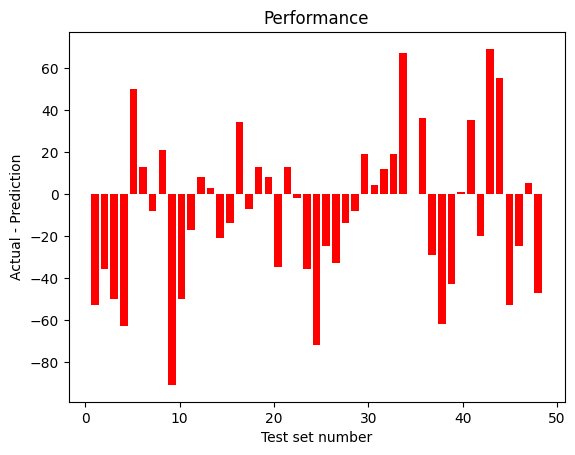

In [49]:
DT(X_train, y_train, X_test, y_test)

[[ 42.1  20. ]
 [ 45.6  25. ]
 [ 51.9  43. ]
 [ 38.2  12. ]
 [ 37.2  58. ]
 [ 18.8  34. ]
 [ 35.6  30. ]
 [ 48.7  82. ]
 [ 35.8   1. ]
 [ 21.5   6. ]
 [ 30.9   0. ]
 [ 36.4  12. ]
 [ 10.7  12. ]
 [ 34.8   4. ]
 [ 19.4   9. ]
 [ 25.7  70. ]
 [ 30.5  54. ]
 [ 23.   25. ]
 [ 24.8  24. ]
 [ 41.3  13. ]
 [ 30.8  46. ]
 [ 31.    7. ]
 [ 33.   57. ]
 [ 35.9  20. ]
 [ 34.4  13. ]
 [ 36.1  18. ]
 [ 12.2   2. ]
 [ 23.5  16. ]
 [ 37.7  50. ]
 [ 48.1  79. ]
 [ 25.6  16. ]
 [ 18.9  38. ]
 [ 19.4  72. ]
 [ 28.2  35. ]
 [ 15.2  50. ]
 [ 33.4  27. ]
 [ 51.6  10. ]
 [ 21.9  56. ]
 [ 63.  101. ]
 [ 37.4  49. ]
 [ 22.3  15. ]
 [ 39.  100. ]
 [ 29.6  62. ]
 [ 45.    0. ]
 [ 46.6   7. ]
 [ 33.9   5. ]
 [ 37.6   1. ]]
r2_score is 0.008102441406853456


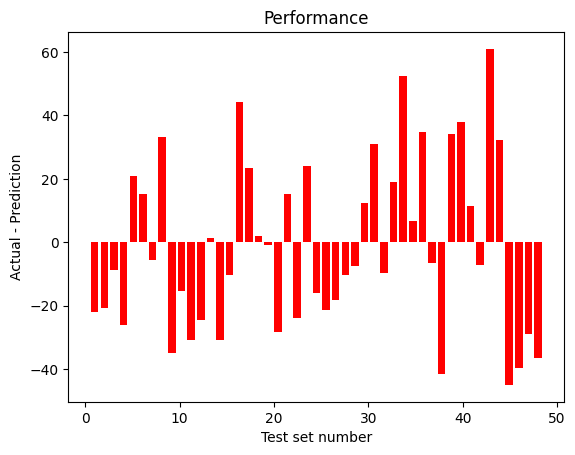

In [50]:
RF(X_train, y_train, X_test, y_test)

[[ 32.62  20.  ]
 [ 28.74  25.  ]
 [ 34.29  43.  ]
 [ 37.26  12.  ]
 [ 34.41  58.  ]
 [ 17.57  34.  ]
 [ 21.71  30.  ]
 [ 26.25  82.  ]
 [ 39.06   1.  ]
 [ 20.53   6.  ]
 [ 39.6    0.  ]
 [  3.96  12.  ]
 [  6.09  12.  ]
 [ 33.77   4.  ]
 [ 25.82   9.  ]
 [ 23.52  70.  ]
 [ 19.04  54.  ]
 [ 25.66  25.  ]
 [ 28.33  24.  ]
 [ 29.22  13.  ]
 [ 28.09  46.  ]
 [ 23.34   7.  ]
 [ 38.11  57.  ]
 [ 34.45  20.  ]
 [ 38.53  13.  ]
 [ 37.75  18.  ]
 [ 16.83   2.  ]
 [ 17.86  16.  ]
 [ 31.72  50.  ]
 [ 47.21  79.  ]
 [ 31.57  16.  ]
 [ 19.76  38.  ]
 [ 11.7   72.  ]
 [ 39.38  35.  ]
 [  9.78  50.  ]
 [ 30.32  27.  ]
 [ 44.07  10.  ]
 [ 31.55  56.  ]
 [ 27.62 101.  ]
 [ 40.01  49.  ]
 [ 31.95  15.  ]
 [ 28.61 100.  ]
 [ 21.63  62.  ]
 [ 24.22   0.  ]
 [ 19.76   7.  ]
 [ 22.61   5.  ]
 [  6.11   1.  ]]
r2_score is -0.10408865422355396


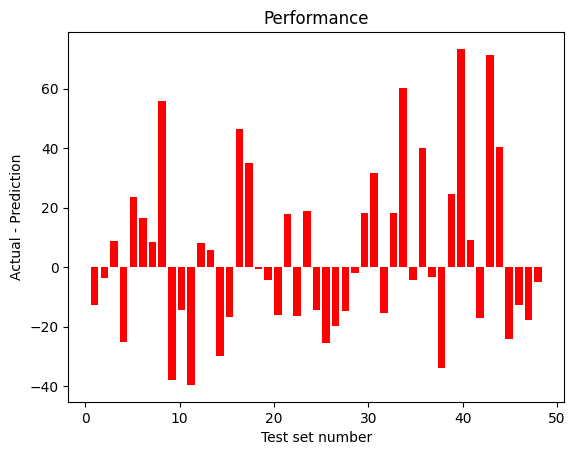

In [51]:
SVR(X_train, y_train, X_test, y_test)